# **Merge dataframes**

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import os
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image
from pathlib import Path

from lynx_id.utils.preprocess.utils import flatten_bbox, get_no_and_multiple_bbox, separate_single_multiple_df, plot_images_conf, absolute_coordinates_bbox
from lynx_id.utils.megadetector.utils import crop_bbox

from idr_pytools import display_slurm_queue, gpu_jobs_submitter, search_log
from megadetector.detection.run_detector_batch import load_and_run_detector_batch, write_results_to_file
from megadetector.utils import path_utils

os.environ['WANDB_DISABLED'] = 'true'  # for megadetector

pd.set_option('display.max_colwidth', None)

## **Merge**

In [3]:
DATASET = Path("/gpfsscratch/rech/ads/commun/datasets/extracted/")

In [4]:
# Load them locally
france_dataset = pd.read_csv(DATASET / "france" / "lynx_dataset_france.csv")
croatia_dataset = pd.read_csv(DATASET / "croatia" / "lynx_dataset_croatia.csv")
slovenia_dataset = pd.read_csv(DATASET / "slovenia" / "lynx_dataset_slovenia.csv")
germany_dataset = pd.read_csv(DATASET / "germany" / "lynx_dataset_germany.csv")
norway_dataset = pd.read_csv(DATASET / "norway" / "lynx_dataset_norway.csv")
swiss_dataset = pd.read_csv(DATASET / "swiss" / "lynx_dataset_swiss.csv")
spain_dataset = pd.read_csv(DATASET / "spain" / "lynx_dataset_spain.csv")

print(f"{france_dataset.shape=}")
print(f"{croatia_dataset.shape=}")
print(f"{slovenia_dataset.shape=}")
print(f"{germany_dataset.shape=}")
print(f"{norway_dataset.shape=}")
print(f"{swiss_dataset.shape=}")
print(f"{spain_dataset.shape=}")

france_dataset.shape=(3081, 15)
croatia_dataset.shape=(1663, 21)
slovenia_dataset.shape=(1945, 18)
germany_dataset.shape=(5115, 15)
norway_dataset.shape=(9682, 15)
swiss_dataset.shape=(22404, 15)
spain_dataset.shape=(1536, 15)


In [5]:
df_full = pd.concat([france_dataset, croatia_dataset, slovenia_dataset, germany_dataset, swiss_dataset, spain_dataset], ignore_index=True)
df_full[['filepath', 'lynx_id', 'country']]

filepath  \
0      /gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OCS/OCS_Van-Gogh/Van-Gogh_OCS_NA_2012-04-27_NA_5.JPG   
1      /gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OCS/OCS_Van-Gogh/Van-Gogh_OCS_NA_2012-05-05_NA_1.JPG   
2      /gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OCS/OCS_Van-Gogh/Van-Gogh_OCS_NA_2012-03-17_NA_3.JPG   
3      /gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OCS/OCS_Van-Gogh/Van-Gogh_OCS_NA_2012-03-16_NA_6.JPG   
4      /gpfsscratch/rech/ads/commun/datasets/extracted/france/Deep learning lynx - data/0_dataset_raw/0_dataset_Marie_OCS/OCS_Van-Gogh/Van-Gogh_OCS_NA_2012-03-05_NA_7.JPG   
...                                                                                                                                                                    ...   
35739                                                                                   /gpfsscratch/rech/ads/commun/datasets/extracted/spain/data/images/Malabar  (8).jpg   
35740                                                                                      /gpfsscratch/rech/ads/commun/datasets/extracted/spain/data/images/Arce (26).jpg   
35741                                                                                   /gpfsscratch/rech/ads/commun/datasets/extracted/spain/data/images/Piqueros (7).JPG   
35742                                                                                     /gpfsscratch/rech/ads/commun/datasets/extracted/spain/data/images/RELICTO_I1.jpg   
35743                                                                                      /gpfsscratch/rech/ads/commun/datasets/extracted/spain/data/images/Arce (11).jpg   

        lynx_id country  
0      van-gogh  France  
1      van-gogh  France  
2      van-gogh  France  
3      van-gogh  France  
4      van-gogh  France  
...         ...     ...  
35739   malabar   spain  
35740      arce   spain  
35741  piqueros   spain  
35742   relicto   spain  
35743      arce   spain  

[35744 rows x 3 columns]

In [6]:
all(df_full['filepath'].apply(os.path.exists))

True

In [7]:
all(df_full['filepath_no_bg'].apply(os.path.exists))

True

Note: the Norwegian dataset has not yet been added.

## **Number of images per country**

<Axes: xlabel='country'>

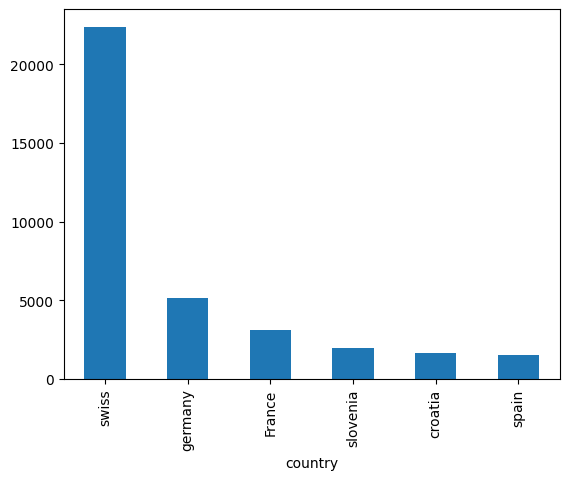

In [8]:
df_full['country'].value_counts().plot(kind='bar')

## **Are the same lynx_ids used in different countries?**

In [9]:
df_full.nunique()['lynx_id']

1771

In [10]:
france_dataset.nunique()['lynx_id'] + croatia_dataset.nunique()['lynx_id'] + slovenia_dataset.nunique()['lynx_id'] + germany_dataset.nunique()['lynx_id'] + swiss_dataset.nunique()['lynx_id'] + spain_dataset.nunique()['lynx_id']

1976

Some lynx_ids are redundant between countries. Let's take a look at which ones and in which countries they apply.

In [11]:
lynx_country_counts = df_full.groupby(['lynx_id', 'country']).size().reset_index(name='count')
lynx_country_counts

lynx_id   country  count
0         01     swiss      3
1         02     swiss     13
2         03     swiss      2
3         04     swiss     13
4         05     swiss     11
...      ...       ...    ...
1971    zita   croatia     10
1972    zita     swiss      2
1973    zois  slovenia      4
1974    zoro     swiss     12
1975   šiljo   croatia      1

[1976 rows x 3 columns]

In [12]:
lynx_id_country_groups = lynx_country_counts.groupby('lynx_id').agg({'country': lambda x: list(x), 'count': lambda x: list(x)}).reset_index()
lynx_id_country_groups

lynx_id           country    count
0         01           [swiss]      [3]
1         02           [swiss]     [13]
2         03           [swiss]      [2]
3         04           [swiss]     [13]
4         05           [swiss]     [11]
...      ...               ...      ...
1766    zikh           [swiss]      [6]
1767    zita  [croatia, swiss]  [10, 2]
1768    zois        [slovenia]      [4]
1769    zoro           [swiss]     [12]
1770   šiljo         [croatia]      [1]

[1771 rows x 3 columns]

In [13]:
shared_lynx_ids = lynx_id_country_groups[lynx_id_country_groups['country'].apply(len) > 1]
shared_lynx_ids

lynx_id           country     count
9         10  [germany, swiss]   [2, 11]
10       100   [France, swiss]    [5, 7]
27      1015   [France, swiss]    [3, 3]
29      1017   [France, swiss]    [2, 3]
30      1018   [France, swiss]    [2, 2]
...      ...               ...       ...
1450    mata   [France, swiss]   [3, 78]
1483    naia    [spain, swiss]  [15, 46]
1527    odin  [croatia, swiss]    [4, 1]
1734    toni  [croatia, swiss]   [35, 1]
1767    zita  [croatia, swiss]   [10, 2]

[202 rows x 3 columns]

In [14]:
for index, row in shared_lynx_ids.iterrows():
    countries_counts = ', '.join([f"{country}: {count}" for country, count in zip(row['country'], row['count'])])
    if 'croatia' in row['country'] and 'germany' in row['country']:
        print(f"{row['lynx_id']}\t | {countries_counts}")

As the notation is country-specific, we are adding a suffix to the lynx_id corresponding to the country.

In [15]:
country_mapping = {
    "France": "FR",
    "croatia": "HR",
    "slovenia": "SI",
    "germany": "DE",
    "swiss": "CH",
    "spain": "ES"
}

In [16]:
df_full['lynx_id'] = df_full.apply(lambda row: f"{row['lynx_id']}_{country_mapping.get(row['country'])}", axis=1)

In [17]:
df_full.nunique()['lynx_id']

1976

In [18]:
# print(set(df_full['lynx_id'].tolist()))

## **View some images**

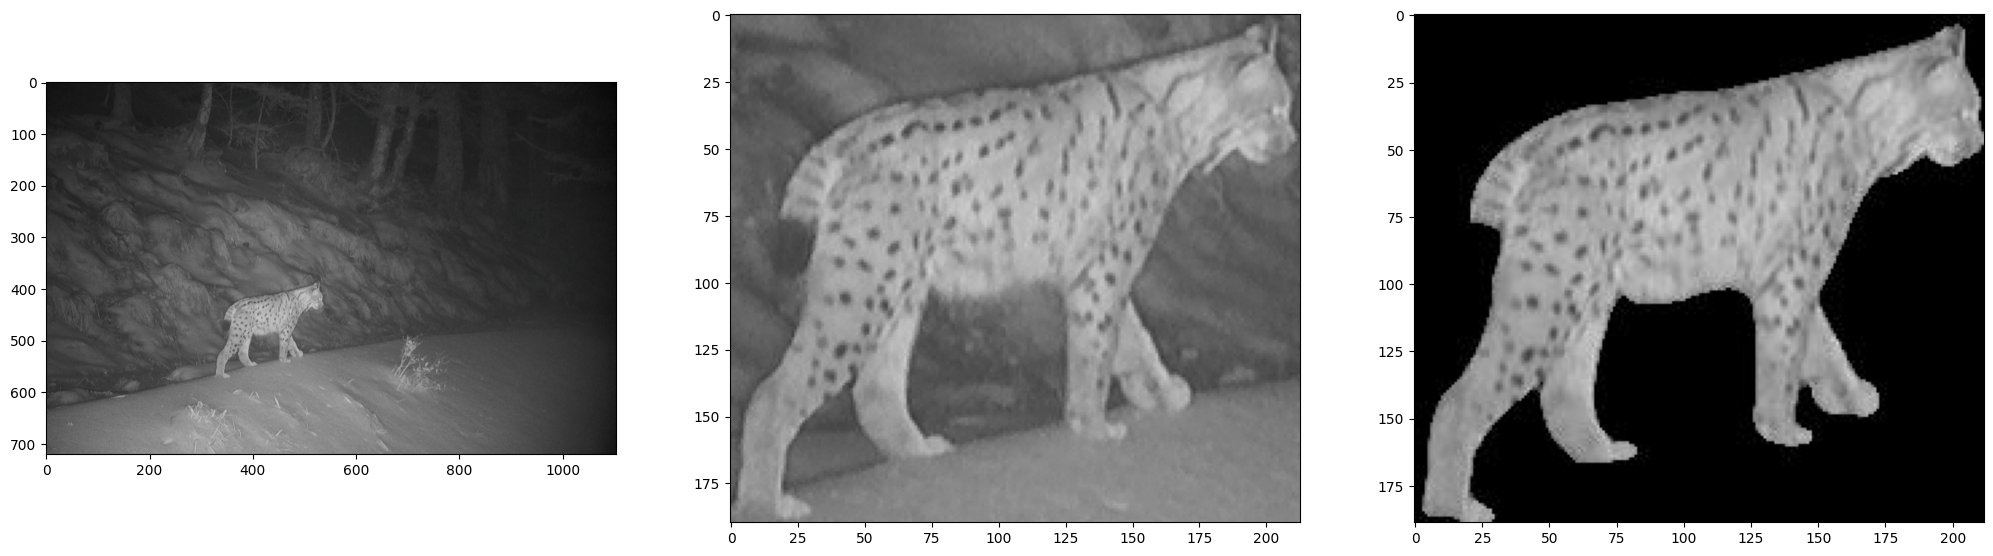

In [19]:
idx=10

fig, axes = plt.subplots(1, 3, figsize=(25,10))

axes[0].imshow(Image.open(df_full.iloc[idx]['filepath']))
axes[1].imshow(crop_bbox(df_full.iloc[idx]))
axes[2].imshow(Image.open(df_full.iloc[idx]['filepath_no_bg']))

## **Save to csv**

In [20]:
df_full.to_csv(DATASET / f"lynx_dataset_full_v2.csv", index=False)